In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import userdata
token =userdata.get('Cryptonite-Token')

## BPE Tokenizer

In [4]:
path = '/content/AllCombined.txt'
text = open(path, 'r', encoding='utf-8').read()
words = text.split()
truncated_words = words[:50000]
truncated_text = ' '.join(truncated_words)
byte_tokens = truncated_text.encode('utf-8')
tokens = list(byte_tokens)

In [5]:
class BPETokenizer:
    def __init__(self):
        self.merges = {}
        self._vocab = {idx: bytes([idx]) for idx in range(256)}
        self._base_vocab_size = 256

    def get_stats(self, ids):
        counts = {}
        for pair in zip(ids, ids[1:]):
            counts[pair] = counts.get(pair, 0) + 1
        return counts

    def _merge(self, ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        return newids

    def train(self, text, vocab_size):
        ids = list(text.encode('utf-8'))
        num_merges = vocab_size - self._base_vocab_size

        for i in range(num_merges):
            stats = self.get_stats(ids)
            if not stats:
                break
            max_pair = max(stats, key=stats.get)
            idx = self._base_vocab_size + i
            ids = self._merge(ids, max_pair, idx)
            self.merges[max_pair] = idx
            self._vocab[idx] = self._vocab[max_pair[0]] + self._vocab[max_pair[1]]


    def encode(self, text):
        ids = list(text.encode('utf-8'))

        while True:
            stats = self.get_stats(ids)
            best_pair = None
            min_idx = float('inf')

            for pair, count in stats.items():
                if pair in self.merges:
                    current_idx = self.merges[pair]
                    if current_idx < min_idx:
                        min_idx = current_idx
                        best_pair = pair

            if best_pair is None:
                break

            ids = self._merge(ids, best_pair, self.merges[best_pair])
        return ids

    def decode(self, ids):
        decoded_bytes = b"".join(self._vocab[token_id] for token_id in ids)
        return decoded_bytes.decode('utf-8', errors='replace')

In [6]:
import tensorflow as tf
import numpy as np

class CBOW(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim=384, num_sampled=64):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_sampled = num_sampled

        self.input_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name="input_embeddings"
        )

        self.nce_weights = tf.Variable(tf.random.truncated_normal([vocab_size, embedding_dim], stddev=1.0 / np.sqrt(embedding_dim)),name="nce_weights")
        self.nce_biases = tf.Variable(tf.zeros([vocab_size]),name="nce_biases")
        self.global_average = tf.keras.layers.GlobalAveragePooling1D()

    def call(self, inputs):
        embeds = self.input_embeddings(inputs)
        context_vector = self.global_average(embeds)
        return context_vector

    def train_step(self, data):
        context, target = data

        with tf.GradientTape() as tape:
            context_vector = self(context, training=True)
            loss = tf.nn.nce_loss(
                weights=self.nce_weights,
                biases=self.nce_biases,
                labels=target,
                inputs=context_vector,
                num_sampled=self.num_sampled,
                num_classes=self.vocab_size
            )
            loss = tf.reduce_mean(loss)

        trainable_vars = self.trainable_variables + [self.nce_weights, self.nce_biases]
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}

In [7]:
def generate_cbow_data(token_ids, window_size=2):
    contexts = []
    targets = []

    for i in range(window_size, len(token_ids) - window_size):
        target = token_ids[i]

        left_context = token_ids[i - window_size : i]
        right_context = token_ids[i + 1 : i + 1 + window_size]
        current_context = left_context + right_context

        contexts.append(current_context)
        targets.append(target)

    return np.array(contexts), np.array(targets).reshape(-1, 1)

In [8]:
rows = []
with open("/content/Sentences_AllAgree.txt", "r", encoding="latin-1") as f:
    for line in f:
        line = line.strip()
        if line:
            s, y = line.rsplit("@", 1)
            rows.append([s, y])

df = pd.DataFrame(rows, columns=["Sentence", "Sentiment"])
df.head()

,Sentence,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


Text(0, 0.5, 'Count')

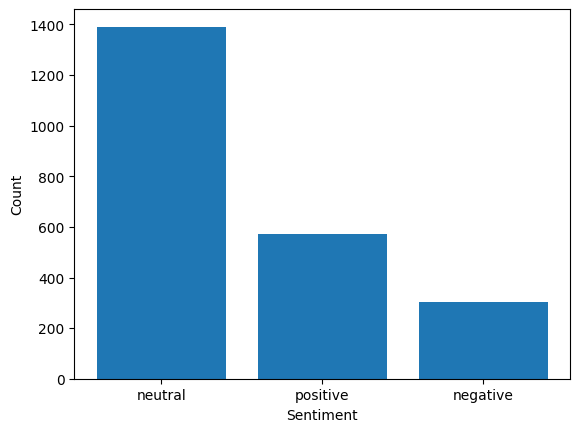

In [9]:
plt.bar(df['Sentiment'].unique(),df['Sentiment'].value_counts())
plt.xlabel('Sentiment')
plt.ylabel('Count')

In [12]:
tokenizer = BPETokenizer()
vocab_size = 15000
tokenizer.train(truncated_text, vocab_size)

print(f"Trained BPE Tokenizer with vocabulary size: {len(tokenizer._vocab)}")

Trained BPE Tokenizer with vocabulary size: 15000


In [13]:
token_ids = tokenizer.encode(truncated_text)
print(f"First 10 token IDs: {token_ids[:10]}")

First 10 token IDs: [14999, 5894, 5895, 2497, 5894, 2707, 3129, 7963, 4072, 5895]


In [14]:
contexts, targets = generate_cbow_data(token_ids, window_size=15)

In [15]:
cbow_model = CBOW(vocab_size=len(tokenizer._vocab))

In [17]:
cbow_model = CBOW(vocab_size=len(tokenizer._vocab))
cbow_model.compile(optimizer=tf.keras.optimizers.Adam())
cbow_model.fit(contexts, targets, epochs=10, batch_size=128)

Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - loss: 184.1803
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - loss: 118.2801
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 80.6106
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - loss: 58.8171
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 44.9291
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - loss: 32.6375
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 26.2367
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - loss: 21.1992
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 81s 118ms/step - loss: 17.5577
Epoch 10/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - loss: 13.9988


In [18]:
import os
drive_dir = '/content/drive/MyDrive/Model_Weights'

if not os.path.exists(drive_dir):
    os.makedirs(drive_dir)

model_save_path = os.path.join(drive_dir, 'CBOW_Task0.h5')
cbow_model.save(model_save_path)

In [19]:
def tokenize_sentences(text):
    return tokenizer.encode(text)

df['tokenized_sentences'] = df['Sentence'].apply(tokenize_sentences)

In [20]:
def get_document_embedding(token_ids_list):
    if not token_ids_list:

        return np.zeros(cbow_model.embedding_dim)
    token_ids_tensor = tf.constant(token_ids_list, dtype=tf.int32)

    embeddings = cbow_model.input_embeddings(token_ids_tensor)

    document_embedding = tf.reduce_mean(embeddings, axis=0)
    return document_embedding.numpy()

df['document_embedding'] = df['tokenized_sentences'].apply(get_document_embedding)

In [21]:
X = np.array(df['document_embedding'].tolist())
y = df['Sentiment']
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
log_reg_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

In [57]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [58]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = sentiment_analyzer.polarity_scores(text)
    compound_score = scores['compound']

    if compound_score >= 0.1:
        return 'positive'
    elif compound_score <= -0.1:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment_pred'] = df['Sentence'].apply(get_vader_sentiment)

In [59]:
y_pred_log_reg = log_reg_model.predict(X_test)

y_vader_encoded = label_encoder.transform(df['vader_sentiment_pred'])

_, y_pred_vader = train_test_split(y_vader_encoded, test_size=0.2, random_state=42)

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluate Logistic Regression Model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, average='macro')
recall_log_reg = recall_score(y_test, y_pred_log_reg, average='macro')
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='macro')

# Evaluate VADER Baseline
accuracy_vader = accuracy_score(y_test, y_pred_vader)
precision_vader = precision_score(y_test, y_pred_vader, average='macro', zero_division=0)
recall_vader = recall_score(y_test, y_pred_vader, average='macro', zero_division=0)
f1_vader = f1_score(y_test, y_pred_vader, average='macro', zero_division=0)



metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Logistic Regression': [accuracy_log_reg, precision_log_reg, recall_log_reg, f1_log_reg],
    'VADER Baseline': [accuracy_vader, precision_vader, recall_vader, f1_vader]
}
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

      Metric  Logistic Regression  VADER Baseline
0   Accuracy             0.651214        0.540839
1  Precision             0.538746        0.456744
2     Recall             0.558956        0.460506
3   F1-Score             0.533765        0.428367


In [61]:
print(classification_report(y_test,y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.32      0.54      0.40        56
           1       0.81      0.82      0.82       276
           2       0.49      0.32      0.39       121

    accuracy                           0.65       453
   macro avg       0.54      0.56      0.53       453
weighted avg       0.66      0.65      0.65       453



In [62]:
print(classification_report(y_test,y_pred_vader))

              precision    recall  f1-score   support

           0       0.21      0.11      0.14        56
           1       0.78      0.55      0.64       276
           2       0.38      0.73      0.50       121

    accuracy                           0.54       453
   macro avg       0.46      0.46      0.43       453
weighted avg       0.60      0.54      0.54       453



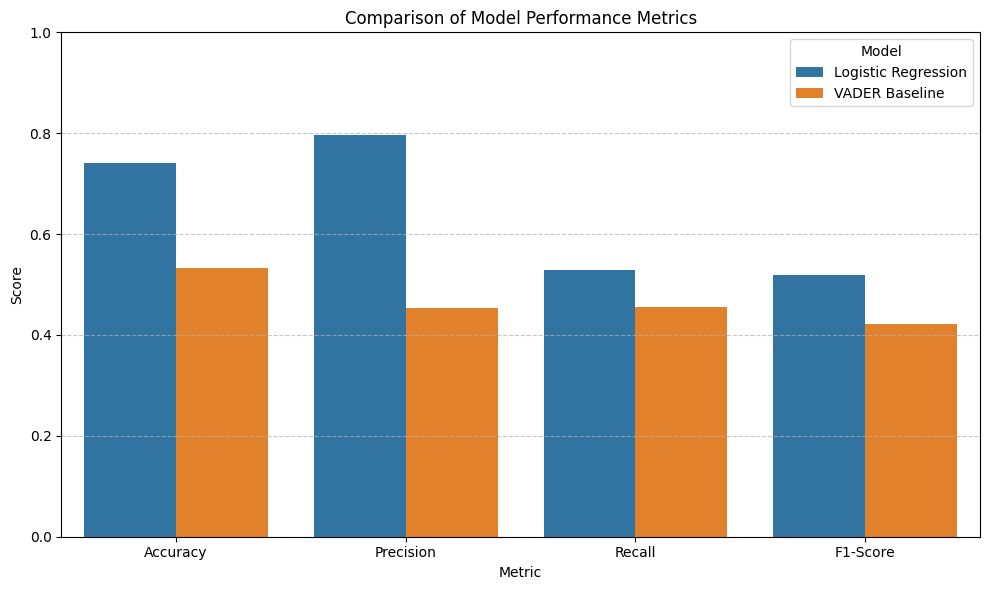

In [62]:
metrics_df_melted = metrics_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_df_melted)
plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are typically between 0 and 1
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

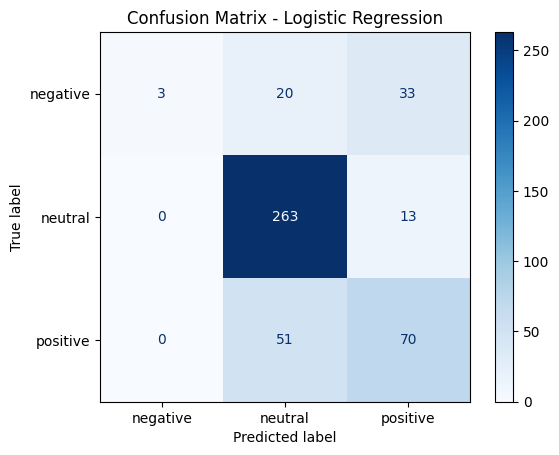

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=label_encoder.classes_)
disp_log_reg.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')

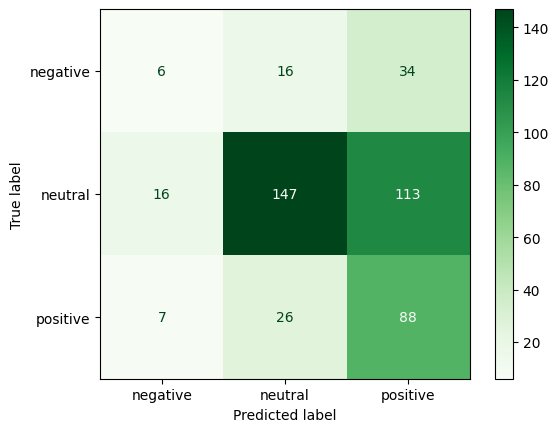

In [66]:
cm_vader = confusion_matrix(y_test, y_pred_vader)
disp_vader = ConfusionMatrixDisplay(confusion_matrix=cm_vader, display_labels=label_encoder.classes_)
disp_vader.plot(cmap=plt.cm.Greens)
plt.show()

In [50]:
y_train_labels = label_encoder.inverse_transform(y_train)
sentiment_distribution_train = pd.Series(y_train_labels).value_counts()
sentiment_percentage_train = pd.Series(y_train_labels).value_counts(normalize=True) * 100

print("Sentiment class distribution in training data:")
print(sentiment_distribution_train)
print("\nSentiment class percentage in training data:")
print(sentiment_percentage_train)

Sentiment class distribution in training data:
neutral     1115
positive     449
negative     247
Name: count, dtype: int64

Sentiment class percentage in training data:
neutral     61.568194
positive    24.792932
negative    13.638874
Name: proportion, dtype: float64


**Reasoning**:
To visualize the class distribution and check for imbalance, I will create a bar chart showing the count of each sentiment class in the training data. This will provide a clear visual representation of the numerical output from the previous step.



/tmp/ipython-input-127294654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_distribution_train.index, y=sentiment_distribution_train.values, palette='viridis')


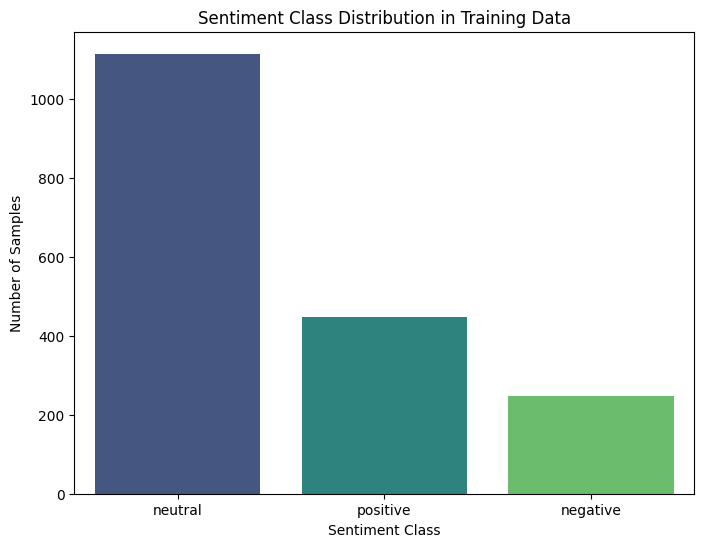

In [51]:
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_distribution_train.index, y=sentiment_distribution_train.values, palette='viridis')
plt.title('Sentiment Class Distribution in Training Data')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.show()